In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt
import graphviz

# Loading Data

In [ ]:
print('Loading data...')
data_path = '/Users/alvira/Desktop/ml1/kaggle/music/'
train = pd.read_csv('train.csv', dtype={'msno' : 'object',
                                                'source_system_tab' : 'object',
                                                  'source_screen_name' : 'object',
                                                  'source_type' : 'object',
                                                  'target' : np.uint8,
                                                  'song_id' : 'object'})
test = pd.read_csv('test.csv', dtype={'msno' : 'object',
                                                'source_system_tab' : 'object',
                                                'source_screen_name' : 'object',
                                                'source_type' : 'object',
                                                'song_id' : 'object'})
songs = pd.read_csv('songs.csv',dtype={'genre_ids': 'object',
                                                  'language' : 'object',
                                                  'artist_name' : 'object',
                                                  'composer' : 'object',
                                                  'lyricist' : 'object',
                                                  'song_id' : 'object'})
members = pd.read_csv('members.csv',dtype={'city' : 'object',
                                                      'bd' : np.uint8,
                                                      'gender' : 'object',
                                                      'registered_via' : 'object'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv')
print('Done loading...')

In [ ]:
def object2cat(df):
    object_cols = list(df.select_dtypes(include=['object']).columns)
    for col in object_cols:
        df[col]=df[col].astype('category')
object2cat(train)
object2cat(test)
object2cat(songs)
object2cat(members)

In [ ]:
#test case for object2cat
assert train['msno'].dtype == 'category'
assert test['source_system_tab'].dtype == 'category'
assert songs['language'].dtype == 'category'
assert members['city'].dtype == 'category'


In [ ]:
songs_extra.head()

In [ ]:
print('Data merging...')

#Merging song with train and test dataframes
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

#Data Extraction/Transformation - Extracting days, months and years from expiratin and registration time 

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']). \
                             dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)


# Converting isrc id to year
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
    

#extracting the year of the song from isrc        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)

#Dropping isrc and name from songs_extra
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
train.msno = train.msno.astype('category')
test = test.merge(members, on='msno', how='left')
test.msno = test.msno.astype('category')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

#deleting redundant dataframes

del members, songs; gc.collect();

print('Done merging...')

In [ ]:
#testing isrc_to_year
assert len(songs_extra['song_year']) != 0


In [ ]:
train.dtypes

In [ ]:
print ("Adding new features")

#counting genre_id
def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1


#filling NA in place of null values
train['genre_ids'].cat.add_categories('no_genre_id').fillna('no_genre_id',inplace=True)
test['genre_ids'].cat.add_categories('no_genre_id').fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)


# Splitting the lyricists by ['|', '/', '\\', ';'] and counting the number of Lyricists
def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'].cat.add_categories('no_lyricist').fillna('no_lyricist',inplace=True)
test['lyricist'].cat.add_categories('no_lyricist').fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)


# Splitting the comoser by ['|', '/', '\\', ';'] and counting the number of Lyricists
def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'].cat.add_categories('no_composer').fillna('no_composer',inplace=True)
test['composer'].cat.add_categories('no_composer').fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

# Checking for feat in the column value
def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'].cat.add_categories('no_artist').fillna('no_artist',inplace=True)
test['artist_name'].cat.add_categories('no_artist').fillna('no_artist',inplace=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

# Splitting the artists by [and, ',', feat, &] and counting the number of artists
def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

In [ ]:
#testing above functions

#testing genre_id_count
assert len(train['genre_ids_count']) != 0
assert len(test['genre_ids_count']) != 0

#testing composer_count
assert len(train['composer_count']) != 0
assert len(train['composer_count']) != 0

#testing lyricist_count
assert len(train['lyricists_count']) != 0
assert len(test['lyricists_count']) != 0

#testing is_feat
assert len(train['is_featured']) != 0
assert len(test['is_featured']) != 0

#testing artist_count
assert len(train['artist_count']) != 0
assert len(test['artist_count']) != 0

In [ ]:
# if artist is same as composer
train['artist_composer'] = (train['artist_name'].astype("object") == train['composer'].astype("object")).astype(np.int8)
test['artist_composer'] = (test['artist_name'].astype("object") == test['composer'].astype("object")).astype(np.int8)


# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((train['artist_name'].astype("object") == train['composer'].astype("object")) & (train['artist_name'].astype("object") == train['lyricist'].astype("object")) & (train['composer'].astype("object") == train['lyricist'].astype("object"))).astype(np.int8)
test['artist_composer_lyricist'] = ((test['artist_name'].astype("object") == test['composer'].astype("object")) & (test['artist_name'].astype("object") == test['lyricist'].astype("object")) & (test['composer'].astype("object") == test['lyricist'].astype("object"))).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)


_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)

# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    

train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)


print("Done adding features")

In [ ]:
#testing the functions

#testing song_lang_boolean
assert train['song_lang_boolean'][0] == 0
assert train['song_lang_boolean'][58] == 1

#testing smaller_song
assert len(test['smaller_song']) != 0
assert len(train['smaller_song']) != 0

#testing count_song_played
assert 'count_song_played' in train
assert len(train['count_artist_played']) != 0
assert 'count_song_played' in test
assert len(test['count_artist_played']) != 0

In [ ]:
print ("Train test and validation sets")
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')


X_train = train.drop(['target'], axis=1)
y_train = train['target'].values


X_test = test.drop(['id'], axis=1)
ids = test['id'].values


# del train, test; gc.collect();

d_train_final = lgb.Dataset(X_train, y_train)
watchlist_final = lgb.Dataset(X_train, y_train)
print('Processed data...')

In [ ]:

train.to_csv("processed_train_1.csv")
test.to_csv("test_1.csv")

In [ ]:
del songs_extra

In [ ]:
gc.collect()

In [2]:
data = pd.read_csv("processed_train_1.csv")

In [3]:
data.head()

,Unnamed: 0,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,359,Bastille,...,1,2,0,0,0,0,0,1,215,1140
1,1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584,1259,Various Artists,...,1,1,0,0,0,0,0,0,1,303616
2,2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396,1259,Nas,...,1,1,0,0,0,0,0,1,4,289
3,3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512,1019,Soundway,...,1,1,0,0,0,0,0,0,1,1
4,4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802,1011,Brett Young,...,1,3,0,0,0,0,0,1,412,427


In [4]:
train = data.drop(data.columns[0], axis=1)

In [5]:
del data
gc.collect()

0

In [6]:
#Converting the columns to category wherever needed
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')        

y_train = train['target'].values
X_train = train.drop(['target'], axis=1)

In [7]:
del train
gc.collect()

7

In [8]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, y_train_all, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=1)

In [9]:
X_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
3080545,1Lshat/Jzw29ax/Z1BW8cbgqE9gwYQuNHAn1vyU4K6I=,Vh95vgpmcpdngmn7WrkbwnT4j+jjzf3hGb6GVTXQLzQ=,my library,Local playlist more,local-playlist,143464,921,ジブリサウンドトラック,NaN,NaN,...,1,1,0,0,0,0,1,1,19,13274
2066956,gDiC609oMU6T+KRowS1tySjuhzrHtsqFU6keH4VNgcY=,eSerI0GiRKmKVwhbY05QQi6DSRrCz4/vhiyvipqURDk=,search,Search,top-hits-for-artist,228832,465,aMEI (張惠妹),Huang Yun Ren,Leng Wan Mei,...,1,1,0,0,0,0,0,1,2351,82799
4284632,Z56mxjHqnR1FK1d5gkf5ARTxwZF8h0HPI+rHFGRrMHo=,uF93OFuDNiSO4ZXM5HEwEzbxOOvZ+/wUPP7ewSaiMYg=,discover,Online playlist more,online-playlist,226089,1259,Gucci Mane,NaN,NaN,...,1,1,0,0,0,0,0,1,44,108
7079336,wgFA/GOJJh187r3NMqvpT22KeEuWhjm5dauTDzqn7F4=,InNESpQNc6sYaS6LD0mc4vtuIeUbfIqX2wM+8QgKxS4=,discover,Online playlist more,online-playlist,280346,458,池石鎮+胡琳,淩偉文,林明陽/十方,...,2,1,0,0,0,0,0,0,884,884
5710192,Z7EGGBgtVEPJmI7+RyTXLFZP/2i5O/UwaxSGpKX/FWM=,rFLawM8j/vW78o/S3P2GTsmy6HwkTI15P7NF/i9CkX4=,discover,Online playlist more,online-playlist,237505,465|458,林芯儀 (Shennio Lin),吳姝霆,張鵬鵬,...,1,1,0,0,0,0,0,1,4775,12727


# Model Fitting

In [12]:
# Sampled train data 
random.seed(130)
idx = random.sample(range(0,X_train.shape[0]), 500000)
y_train = pd.DataFrame(y_train)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

Let's try to fit a small model to visualise the splitting

In [10]:
small_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3,
                                         verbose=0,
                                         max_depth= 2)

small_model.fit(X_train, y_train)

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, eval_metric='binary_logloss',
        importance_type='split', learning_rate=0.3, max_depth=2,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=0)

Plotting 84th tree...


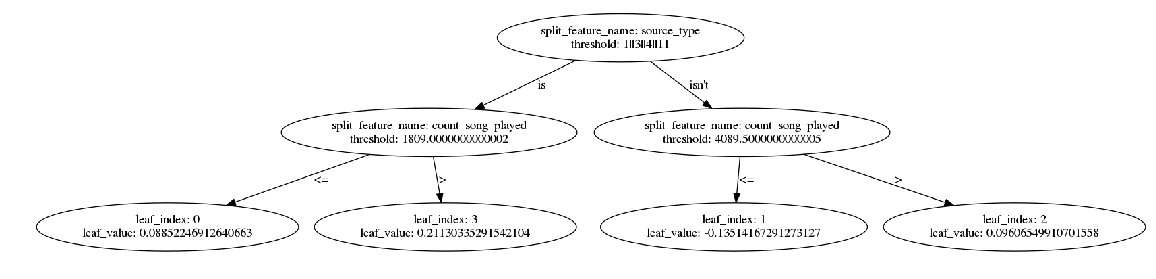

In [11]:
print('Plotting 84th tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(small_model, tree_index=1, figsize=(20, 8))
plt.show()

# print('Plotting 84th tree with graphviz...')
# graph = lgb.create_tree_digraph(small_model, tree_index=1, name='Tree84')
# graph.render(view=True)

In [13]:
#Fitting a model on sampled data
sk_reg = lgb.sklearn.LGBMClassifier(
         objective='binary',
         eval_metric='binary_logloss',
         boosting='gbdt',
         learning_rate=0.3 ,
         verbose=0,
         num_leaves=600,
         bagging_freq= 1,
         bagging_seed= 1,
         feature_fraction= 0.9,
         feature_fraction_seed= 1,
         max_bin= 256,
         max_depth= 300,
         num_rounds= 200,
)


sk_reg.fit(X_train_sampled, y_train_sampled)



/home/aditi/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aditi/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aditi/anaconda3/envs/ml/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_freq=1, bagging_seed=1, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='binary_logloss', feature_fraction=0.9,
        feature_fraction_seed=1, importance_type='split',
        learning_rate=0.3, max_bin=256, max_depth=300,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=600, num_rounds=200,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [15]:
predicted = sk_reg.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.685


### Feature selection

                   cols    imp
0                  msno  37637
32    count_song_played  11544
1               song_id  11347
7           artist_name   8607
5           song_length   6228
33  count_artist_played   5983
16      membership_days   5044
8              composer   4990
22            song_year   3993
19    registration_date   3642


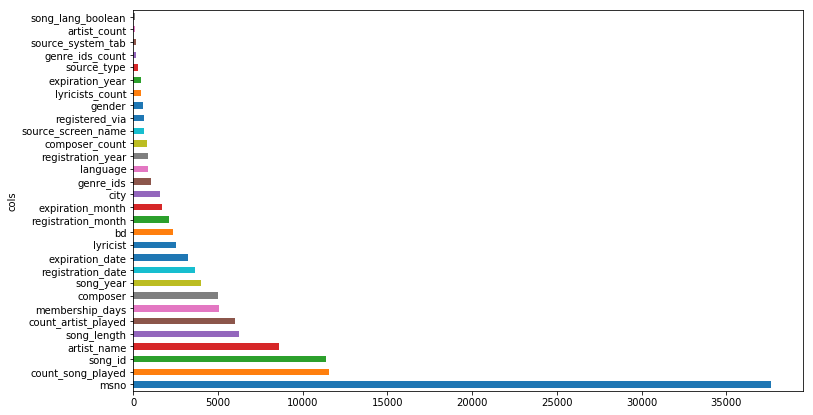

In [16]:
### Feature selection

def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = lgb_feat_importance(sk_reg, X_train_sampled ); 
print(fi[:10])

def plot_fi(fi):return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])
plt.show()

In [17]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', lgb.sklearn.LGBMClassifier())]) # Estimator: ML algorithm

grid_params = dict(
         clf__objective=['binary'],
         clf__eval_metric=['binary_logloss'],
         clf__boosting_type=['gbdt'],
         clf__learning_rate=[0.3] ,
         clf__verbose=[0],
         clf__num_leaves=[300,500,700],
         clf__feature_fraction= [0.9],
         clf__feature_fraction_seed= [1],
         clf__max_bin= [256],
         clf__max_depth= [200,250,300],
         clf__num_rounds= [200])
gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

/home/aditi/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aditi/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aditi/anaconda3/envs/ml/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


'0.6855'

In [18]:
# Best algorithm with best hyperparameters (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
     steps=[('clf', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='binary_logloss', feature_fraction=0.9,
        feature_fraction_seed=1, importance_type='split',
        learning_rate=0.3, max_bin=256, max_depth=250,
        min_child_samples=20, min_...da=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0))])


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='binary_logloss', feature_fraction=0.9,
        feature_fraction_seed=1, importance_type='split',
        learning_rate=0.3, max_bin=256, max_depth=250,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=300, num_rounds=200,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [19]:
#Fitting the best model on all the data
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=600,
                                         bagging_freq= 1,
                                         bagging_seed= 1,
                                         feature_fraction= 0.9,
                                         feature_fraction_seed= 1,
                                         max_bin= 256,
                                         max_depth= 300,
                                         num_rounds= 200)


In [20]:
#Validation accuracy
Final_model.fit(X_train, y_train)
predicted = Final_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.742


In [21]:
# Test accuracy
predicted = Final_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.742


# Evautation Metric

In [22]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [0.73751855 0.74709601]
recall: [0.74618197 0.73845285]
fscore: [0.74182497 0.74274928]
support: [732119 743365]


Confusion matrix, without normalization
[[546294 185825]
 [194425 548940]]
Normalized confusion matrix
[[0.75 0.25]
 [0.26 0.74]]


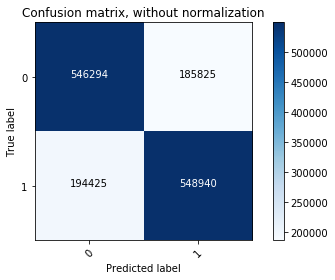

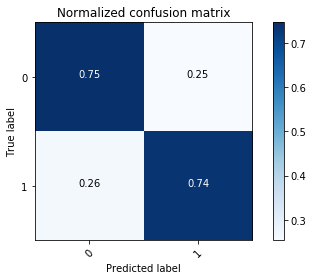

In [23]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
